## Setup

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from agents.utils import get_config, smooth
from agents.agents import (DeepQAgent, DoubleDeepQAgent, 
                           DuelingDeepQAgent, DuelingDoubleDeepQAgent)                  
from tqdm.auto import tqdm

In [2]:
# Set global variables
WEIGHTS_DIR = 'agents/weights'

################ Define this as explained in README.md ################
BANANA_PATH = 'environment/banana_windows/Banana.exe'
#######################################################################

NUM_EPISODES = 1000

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [3]:
# Initialize agents and environment
agents = []
for agent in [DeepQAgent, DoubleDeepQAgent, DuelingDeepQAgent, DuelingDoubleDeepQAgent]:
    for (prioritising, noisy) in [(False, False), (False, True), (True, False), (True, True)]:
        agent_config = get_config()
        agent_config.noisy = noisy
        agent_config.prioritising = prioritising
        agents.append(agent(config=agent_config))
    
env = UnityEnvironment(file_name=BANANA_PATH)

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Training Day

In [4]:
# A function used to play one episode with a given agent
def play_one(agent, env, brain_name, train_mode=True):
    
    # Initialize the return
    episode_return = 0
    
    # Start episode
    env_info = env.reset(train_mode=train_mode)[brain_name]
    observation = env_info.vector_observations[0]
    done = False
    
    # Play
    while not done:
        # Interact with environment
        action = agent.act(observation)
        env_info = env.step(action)[brain_name]
        next_observation = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        episode_return += reward     

        # Add memory
        agent.memento(observation, action, reward, next_observation, done)
        # Train from memory
        agent.learn()
        
        # Perform transition
        observation = next_observation
    
    return episode_return

In [5]:
# Populating replay buffer (while acting randomly, all agents share the same experience):
env_info = env.reset(train_mode=True)[brain_name]
observation = env_info.vector_observations[0]
done = False

print('Filling Replay Buffer...')
while not agents[0].memory.is_ready():
    action = np.random.choice(4)
    env_info = env.step(action)[brain_name]
    reward = env_info.rewards[0]
    next_observation = env_info.vector_observations[0]
    done = env_info.local_done[0]

    # Add memory
    for agent in agents:
        agent.memento(observation, action, reward, next_observation, done)
    
    observation = next_observation
    if done:
        env_info = env.reset(train_mode=True)[brain_name]
        observation = env_info.vector_observations[0]
        
print('Done.')

Filling Replay Buffer...
Done.


In [6]:
# Now we are able to train our agents
episode_returns = np.zeros([len(agents), NUM_EPISODES])

for i, agent in enumerate(agents):
    print(f'{agent.name}: Starting Training...')
    for j in tqdm(range(NUM_EPISODES)):
        episode_returns[i, j] = play_one(agent, env, brain_name)
        if j % (NUM_EPISODES // 4) == 0 and j > 0:
            print(f'{agent.name}: Average Return over the last 100 episodes: {smooth(episode_returns[i, :j+1])[-1]}')
    print(f'{agent.name}: Done.')

Deep-Q-Agent: Starting Training...


Deep-Q-Agent: Average Return over the last 100 episodes: 7.0
Deep-Q-Agent: Average Return over the last 100 episodes: 12.51
Deep-Q-Agent: Average Return over the last 100 episodes: 13.61

Deep-Q-Agent: Done.
Noisy-Deep-Q-Agent: Starting Training...


Noisy-Deep-Q-Agent: Average Return over the last 100 episodes: 9.75
Noisy-Deep-Q-Agent: Average Return over the last 100 episodes: 13.85
Noisy-Deep-Q-Agent: Average Return over the last 100 episodes: 11.98

Noisy-Deep-Q-Agent: Done.
Prioritising-Deep-Q-Agent: Starting Training...


Prioritising-Deep-Q-Agent: Average Return over the last 100 episodes: 8.32
Prioritising-Deep-Q-Agent: Average Return over the last 100 episodes: 14.02
Prioritising-Deep-Q-Agent: Average Return over the last 100 episodes: 14.32

Prioritising-Deep-Q-Agent: Done.
Noisy-Prioritising-Deep-Q-Agent: Starting Training...


Noisy-Prioritising-Deep-Q-Agent: Average Return over the last 100 episodes: 9.36
Noisy-Prioritising-Deep-Q-Agent: Average Return over the last 100 episodes: 13.02
Noisy-Prioritising-Deep-Q-Agent: Average Return over the last 100 episodes: 15.02

Noisy-Prioritising-Deep-Q-Agent: Done.
Double-Deep-Q-Agent: Starting Training...


Double-Deep-Q-Agent: Average Return over the last 100 episodes: 10.47
Double-Deep-Q-Agent: Average Return over the last 100 episodes: 13.27
Double-Deep-Q-Agent: Average Return over the last 100 episodes: 13.95

Double-Deep-Q-Agent: Done.
Noisy-Double-Deep-Q-Agent: Starting Training...


Noisy-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 10.49
Noisy-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 11.98
Noisy-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 15.09

Noisy-Double-Deep-Q-Agent: Done.
Prioritising-Double-Deep-Q-Agent: Starting Training...


Prioritising-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 6.96
Prioritising-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 12.94
Prioritising-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 13.65

Prioritising-Double-Deep-Q-Agent: Done.
Noisy-Prioritising-Double-Deep-Q-Agent: Starting Training...


Noisy-Prioritising-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 8.2
Noisy-Prioritising-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 12.7
Noisy-Prioritising-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 14.17

Noisy-Prioritising-Double-Deep-Q-Agent: Done.
Dueling-Deep-Q-Agent: Starting Training...


Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 10.74
Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 11.64
Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 13.82

Dueling-Deep-Q-Agent: Done.
Noisy-Dueling-Deep-Q-Agent: Starting Training...


Noisy-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 11.57
Noisy-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 13.89
Noisy-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 13.13

Noisy-Dueling-Deep-Q-Agent: Done.
Prioritising-Dueling-Deep-Q-Agent: Starting Training...


Prioritising-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 7.61
Prioritising-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 13.01
Prioritising-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 13.1

Prioritising-Dueling-Deep-Q-Agent: Done.
Noisy-Prioritising-Dueling-Deep-Q-Agent: Starting Training...


Noisy-Prioritising-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 12.68
Noisy-Prioritising-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 13.2
Noisy-Prioritising-Dueling-Deep-Q-Agent: Average Return over the last 100 episodes: 13.93

Noisy-Prioritising-Dueling-Deep-Q-Agent: Done.
Dueling-Double-Deep-Q-Agent: Starting Training...


Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 10.15
Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 11.09
Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 13.39

Dueling-Double-Deep-Q-Agent: Done.
Noisy-Dueling-Double-Deep-Q-Agent: Starting Training...


Noisy-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 11.73
Noisy-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 13.2
Noisy-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 14.49

Noisy-Dueling-Double-Deep-Q-Agent: Done.
Prioritising-Dueling-Double-Deep-Q-Agent: Starting Training...


Prioritising-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 9.04
Prioritising-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 12.49
Prioritising-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 13.13

Prioritising-Dueling-Double-Deep-Q-Agent: Done.
Noisy-Prioritising-Dueling-Double-Deep-Q-Agent: Starting Training...


Noisy-Prioritising-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 9.21
Noisy-Prioritising-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 13.39
Noisy-Prioritising-Dueling-Double-Deep-Q-Agent: Average Return over the last 100 episodes: 14.79

Noisy-Prioritising-Dueling-Double-Deep-Q-Agent: Done.


Text(0.5, 1.0, 'Returns averaged over the last 100 episodes')

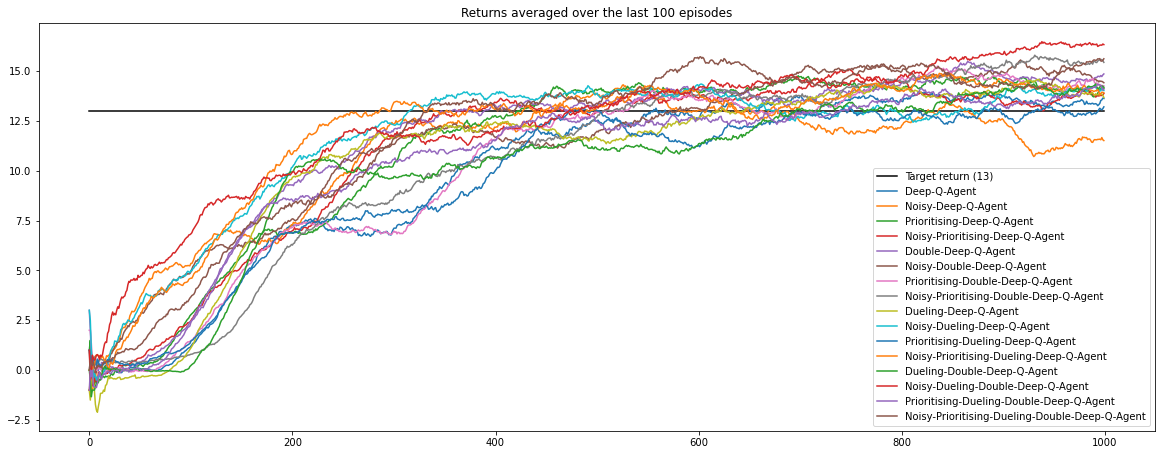

In [7]:
# Plot the results:
plt.figure(figsize=(20,7.5))
plt.plot(np.ones(NUM_EPISODES)*13, color='black', label='Target return (13)')
for i, agent in enumerate(agents):
    plt.plot(smooth(episode_returns[i, :]), label=f'{agent.name}')
plt.legend()
plt.title('Returns averaged over the last 100 episodes')

In [8]:
# Save weights
for agent in agents:
    agent.save(f'{WEIGHTS_DIR}/{agent.name}.pt')

## Cleanup

In [9]:
env.close()